In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from modAL.uncertainty import uncertainty_sampling
from data_utils import get_cifar10, get_dataloader

## Setting seed and device-agnostic code

In [3]:
np.random.seed(13)
torch.manual_seed(13)
torch.cuda.manual_seed(13)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data preparation

In [4]:
train_data, test_data = get_cifar10()
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [5]:
indices = np.arange(len(train_data))
np.random.shuffle(indices)

initial_labeled_size = 1000
labeled_indices = indices[:initial_labeled_size].tolist()
unlabeled_indices = indices[initial_labeled_size:].tolist()

## Small CNN model

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 512, 3, padding='same')
        self.conv2 = nn.Conv2d(512, 256, 3, padding='same')
        self.conv3 = nn.Conv2d(256, 256, 3, padding='same')
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(4 * 4 * 256, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x: torch.Tensor):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Train utilities

In [7]:
def train_model(model, train_loader, device, epochs=3):
    model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        for data, label in train_loader:
            data, label = data.to(device), label.to(device)
            optimizer.zero_grad()
            loss = criterion(model(data), label)
            loss.backward()
            optimizer.step()

In [8]:
def test_model(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.inference_mode():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            outputs = model(data)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == label).sum().item()
            total += label.size(0)
    return 100 * correct / total

## Uncertainty sampling

In [9]:
def query_uncertainty_sampling(model, unlabeled_indices, n_instances, device):
    model.eval()
    subset = Subset(train_data, unlabeled_indices)
    loader = DataLoader(subset, batch_size=128, shuffle=False)

    all_probs = []
    for data, _ in loader:
        data = data.to(device)
        with torch.inference_mode():
            outputs = model(data)
            probs = torch.nn.functional.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

    all_probs = np.vstack(all_probs)
    uncertainty = 1 - np.max(all_probs, axis=1)
    selected_pos = np.argsort(uncertainty)[-n_instances:]
    selected_indices = [unlabeled_indices[i] for i in selected_pos]
    return selected_indices

In [10]:
train_accs = []
test_accs = []

n_queries = 10
query_batch_size = 500
epochs_per_round = 3

for round_num in range(n_queries):
    print(f"\n=== Round {round_num + 1}/{n_queries} ===")
    
    train_loader = get_dataloader(train_data=train_data, 
                                  indices=labeled_indices, 
                                  batch_size=64,
                                  shuffle=True)
    model = SimpleCNN()
    train_model(model, train_loader, device=device, epochs=epochs_per_round)
    
    train_acc = test_model(model, train_loader, device)
    test_acc = test_model(model, test_loader, device)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    print(f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
    
    if len(unlabeled_indices) == 0:
        break

    selected_indices = query_uncertainty_sampling(model, unlabeled_indices, query_batch_size, device)
    
    labeled_indices.extend(selected_indices)
    unlabeled_indices = list(set(unlabeled_indices) - set(selected_indices))


=== Round 1/10 ===


Train Acc: 37.40% | Test Acc: 31.69%

=== Round 2/10 ===
Train Acc: 37.13% | Test Acc: 34.80%

=== Round 3/10 ===
Train Acc: 40.60% | Test Acc: 37.32%

=== Round 4/10 ===
Train Acc: 35.28% | Test Acc: 33.07%

=== Round 5/10 ===
Train Acc: 44.50% | Test Acc: 43.55%

=== Round 6/10 ===
Train Acc: 48.57% | Test Acc: 45.95%

=== Round 7/10 ===
Train Acc: 42.30% | Test Acc: 44.43%

=== Round 8/10 ===
Train Acc: 46.60% | Test Acc: 45.75%

=== Round 9/10 ===
Train Acc: 42.74% | Test Acc: 45.75%

=== Round 10/10 ===
Train Acc: 40.76% | Test Acc: 45.90%


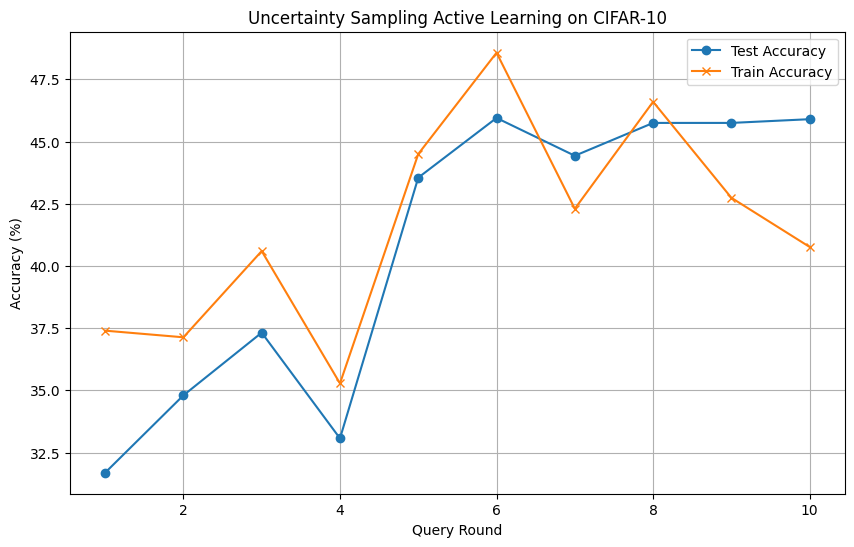

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_queries + 1), test_accs, label='Test Accuracy', marker='o')
plt.plot(range(1, n_queries + 1), train_accs, label='Train Accuracy', marker='x')
plt.xlabel('Query Round')
plt.ylabel('Accuracy (%)')
plt.title('Uncertainty Sampling Active Learning on CIFAR-10')
plt.legend()
plt.grid(True)
plt.show()